# Lesson 1 - Jet tagging with neural networks

> A first look at training deep neural networks to tag jets in proton-proton collisions.

## TODO

* Move `top_quark_tagging` to `dl4phys` org

## Learning objectives

* Understand what jet tagging is and how to frame it as a machine learning task
* Understand the main steps needed to train and evaluate a jet tagger
* Gain an introduction to the fastai library

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) by G. Kasieczka et al.
* [_How Much Information is in a Jet?_](https://arxiv.org/abs/1704.08249) by K. Datta and A. Larkowski.

## The data

For the first few lessons, we'll be analysing the [_Top Quark Tagging_ dataset](https://zenodo.org/record/2603256), which is a famous benchmark that's used to compare the performance of jet classification algorithms. The dataset is described as follows:

* 14 TeV, hadronic tops for signal, qcd diets background, Delphes ATLAS detector card with Pythia8
* No MPI/pile-up included
* Clustering of  particle-flow entries (produced by Delphes E-flow) into anti-kT 0.8 jets in the pT range [550,650] GeV
* All top jets are matched to a parton-level top within ∆R = 0.8, and to all top decay partons within 0.8
* Jets are required to have |eta| < 2
* The leading 200 jet constituent four-momenta are stored, with zero-padding for jets with fewer than 200
* Constituents are sorted by pT, with the highest pT one first
* A flag (1 for top, 0 for QCD) is kept for each jet. It is called is_signal_new

Framed as a supervised machine learning task, the goal is to train a model that can classify each jet as either a top quark signal or quark-gluon background.

<img src="images/jet-tagging.png" alt="fishy" class="bg-primary mb-1" width="600px">

## Import libraries

In [19]:
import torch.nn.functional as F
from datasets import load_dataset
from fastai.tabular.all import *
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [2]:
import datasets

# Suppress logs
datasets.logging.set_verbosity_error()

## Getting the data

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download and process the datasets that we'll encounter in this course. 🤗 Datasets provides smart caching and allows you to process larger-than-RAM datasets by exploiting a technique called _memory-mapping_ that provides a mapping between RAM and filesystem storage.

To download the Top Quark Tagging dataset from the Hugging Face Hub, we can use the `load_dataset()` function:

In [3]:
top_quark_ds = load_dataset("dl4phys/top_landscape")
top_quark_ds

Using custom data configuration dl4phys--top_landscape-961457c8730ac19c


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_landscape-961457c8730ac19c/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28'

To get a quick feel for what type of data we're dealing with, we've selected just the training split associated with the `raw` subset (which contains all the raw events). Since this dataset is rather large with 1.2 million events, we've also enabled _dataset streaming_ so we can grab a sample of events without having to load the whole dataset into RAM. The `take()` method returns the first $n$ examples in the datasets, so let's grab 5 events and load them in a pandas `DataFrame`:

In [4]:
sample = list(top_quark_ds.take(5))
pd.DataFrame(sample)

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,E_199,PX_199,PY_199,PZ_199,truthE,truthPX,truthPY,truthPZ,ttv,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


As we can see, each row consists of 4-vectors $(E_i, p_{x_i}, p_{y_i}, p_{z_i})$ that correspond to the maximum 200 particles that make up each jet. We can also see that each jet has been padded with zeros, since most won't have 200 particles. We also have an `is_signal_new` column that indicates whether the jet is a top quark signal (1) or QCD background (0).

Now that we've had a look at a sample of the raw data, let's take a look at how we can convert it to a format that is suitable for neural networks!

## Jet representations

In any machine learning problem, the first step is to decide how to represent the data. For jet tagging, the most common approaches one finds in the literature include:

* **Jets as images.** A jet image is a pixelated grayscale image, where the pixel intensity represents the energy (or transverse momentum) of all particles that deposited energy in a particular location in the $\eta-\phi$ plane. Typically, _convolutional neural networks (CNNs)_ (which we'll encounter later in the course) are used to process the images.
* **Jets as sequences.** Here the idea is to order the particles in a jet (usually by $p_T$) and use sequence-based architectures like _recurrent neural networks (RNNs)._
* **Jets as graphs.** This approach treats each jet as a generic graph of nodes and edges. Graph neural networks (which we'll also encounter later in the course) excel on this tpe of data.
* **Jets as sets.** A generalisation of the previous representations, this approach simply treats each jets as an unordered collection or point cloud of 4-vectors.
* **Theory-inspired representations.** Instead of representing the jets in formats to match specific neural network architectures, these approaches use results on IR safety from QCD to represent the jets as a simplified set of features. Fully-connected neural networks are then trained on these features.

You can find more details about each representation in a nice [review article](https://arxiv.org/abs/1709.04464) from 2017. 

<img src="images/jets.png" alt="Different ways to represent jets" class="bg-primary mb-1" width="400px">

In this lesson and the next, we'll use one of the theory-inspired representations called $N$-subjettiness. Let's take a look.

### Representing jets with $N$-subjettiness observables

$N$-subjettiness observables quantify how much of the radiation in a jet is aligned along different subjet axes. Although originally used for analytic approaches to distinguish different decays and event topologies, these observable can also be used as inputs for machine learning models and provide strong discriminating power. 

To be precise, an $N$-subjettiness observable $\tau_N^{(\beta)}$ measures the radiation about $N$ axes in the jet according to an angular exponent $\beta>0$:

$$ \tau_N^{(\beta)} = \frac{1}{p_{T,J}} \sum_{i\in J} p_{T,i} \min \left\{ R_{1,i}^\beta, R_{1,i}^\beta, \ldots , R_{1,i}^\beta \right\} $$

Here $p_{T,J}$ is the transverse momentum of the jet, $p_{T,i}$ is the transverse momentum of particle $i$ in the jet, and $R_{K,i}$ is the distance in the $\eta-\phi$ plane of particle $i$ to axis $K$.

To measure substructure in a jet, one thus needs to measure a suitable number of $N$-subjettiness observables. In practice this is done by specifying the corrdinates of $M$-body phase space in terms of $3m - 4$ $N$-subjettiness observables:

$$ \left\{ \tau_1^{(0.5)}, \tau_1^{(1)}, \tau_1^{(2)}, \tau_2^{(0.5)}, \tau_2^{(1)}, \tau_2^{(2)}, \ldots , \tau_{m-1}^{(0.5)}, \tau_{m-1}^{(1)}, \tau_{m-1}^{(2)} \right\} $$

To see how we can use this basis as features for a neural network, we have computed $N$-subjettiness observables up through 4-body phase space using the [Fastjet library](https://github.com/scikit-hep/fastjet). You can download these features by passing the `nsubjetiness` subset to the `load_dataset()` function:

In [4]:
nsubjet_ds = load_dataset("dl4phys/top_landscape_nsubs")

Using custom data configuration dl4phys--top_landscape_nsubs-d6826973a7221144


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_landscape_nsubs-d6826973a7221144/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

If we look inside our `nsubjet_ds` object

In [5]:
nsubjet_ds

DatasetDict({
    train: Dataset({
        features: ['pT', 'mass', 'tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'tau_5_0.5', 'tau_5_1', 'tau_5_2', 'tau_6_0.5', 'tau_6_1', 'tau_6_2', 'label'],
        num_rows: 1211000
    })
    test: Dataset({
        features: ['pT', 'mass', 'tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'tau_5_0.5', 'tau_5_1', 'tau_5_2', 'tau_6_0.5', 'tau_6_1', 'tau_6_2', 'label'],
        num_rows: 404000
    })
    validation: Dataset({
        features: ['pT', 'mass', 'tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'tau_5_0.5', 'tau_5_1', 'tau_5_2', 'tau_6_0.5', 'tau_6_1', 'tau_6_2', 'label'],
        num_rows: 403000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [6]:
train_ds = nsubjet_ds["train"]
train_ds

Dataset({
    features: ['pT', 'mass', 'tau_1_0.5', 'tau_1_1', 'tau_1_2', 'tau_2_0.5', 'tau_2_1', 'tau_2_2', 'tau_3_0.5', 'tau_3_1', 'tau_3_2', 'tau_4_0.5', 'tau_4_1', 'tau_4_2', 'tau_5_0.5', 'tau_5_1', 'tau_5_2', 'tau_6_0.5', 'tau_6_1', 'tau_6_2', 'label'],
    num_rows: 1211000
})

The `Dataset` object is one of the core data structures in 🤗 Datasets and behaves like an ordinary Python `list`, so we can query its length:

In [7]:
len(train_ds)

1211000

or access a single element by its index:

In [8]:
train_ds[0]

{'pT': 543.633943859825,
 'mass': 25.84679198808868,
 'tau_1_0.5': 0.1651217365709237,
 'tau_1_1': 0.0326612823732295,
 'tau_1_2': 0.002261721860060991,
 'tau_2_0.5': 0.048829926384021324,
 'tau_2_1': 0.0037105140267032917,
 'tau_2_2': 4.3909620427956585e-05,
 'tau_3_0.5': 0.030994313687801745,
 'tau_3_1': 0.0016299882278326505,
 'tau_3_2': 1.1181864214922376e-05,
 'tau_4_0.5': 0.024336277786176298,
 'tau_4_1': 0.0011153324466200857,
 'tau_4_2': 7.76589146744022e-06,
 'tau_5_0.5': 0.004252331010666273,
 'tau_5_1': 0.00023385716321281164,
 'tau_5_2': 7.706005223664668e-07,
 'tau_6_0.5': 0.0,
 'tau_6_1': 0.0,
 'tau_6_2': 0.0,
 'label': 0}

Here we see that a single row is repesented as a dictionary where the keys correspond to the column names. Although, 🤗 Datasets provides a lot of low-level functionality for preprocessing datasets, it is often conventient to convert a `Dataset` object to a Pandas `DataFrame`. We can do this by using the `to_pandas()` method as follows:

In [11]:
train_df = train_ds.to_pandas()
train_df.head()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,543.633944,25.846792,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,...,0.024336,0.001115,0.000008,0.004252,0.000234,7.706005e-07,0.000000,0.000000,0.000000e+00,0
1,452.411860,13.388679,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,...,0.056854,0.005454,0.000072,0.044211,0.004430,6.175314e-05,0.037458,0.003396,3.670517e-05,0
2,429.495258,32.021091,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,...,0.078205,0.012678,0.000567,0.052374,0.005935,9.395772e-05,0.037572,0.002932,2.237277e-05,0
3,512.675443,6.684734,0.102580,0.011369,0.000170,0.086306,0.007760,0.000071,0.068169,0.005386,...,0.044705,0.002376,0.000008,0.027895,0.001364,4.400042e-06,0.009012,0.000379,6.731099e-07,0
4,527.956859,133.985415,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,...,0.143768,0.033249,0.003689,0.135407,0.029054,2.593460e-03,0.110805,0.023179,2.202088e-03,0


## Introducing fastai

Now that we've downloaded our dataset of $N$-subjettiness variables, it's time to train a model! To do so, we'll use the [fastai library](https://github.com/fastai/fastai). fastai is the most popular framework for training deep neural networks with PyTorch and provides various application-specific classes for different types of deep learning data structures and architectures. It is also designed with a _layered API_, which means:

* We can use high-level components to quickly and easily get state-of-the-art results in standard deep learning domains
* Low-level components can be mixed and matched to build new approaches

In particular, this approach will allow us in later lessons to use pure PyTorch code to define our models, and then let fastai take care of the training loop (which is often an error-prone process).

**Basics of the API**

The most common steps one takes when training a model in fastai are:

* Create `DataLoaders` to feed batches of data to the model
* Create a `Learner` which wraps the architecture, optimizer, and data, and automatically chooses an appropriate loss function where possible
* Find a good learning rate
* Train your model
* Evaluate your model

Let's go through each of these steps to build a neural network that can classify top quark jets from the QCD background!

### From data to DataLoaders

To wrangle our data in a format that's suitable for training neural nets, we need to create an object called `DataLoaders`. To turn our dataset into a `DataLoaders` object we need to specify:

* What type of data we are dealing with (tabular, images, etc)
* How to get the examples
* How to label each example
* How to create the validation set

fastai provides a number of classes for different kinds of deep learning datasets and problems. In our case, the data is in a _tabular_ format (i.e. a table of rows and columns), so we can use the `TabularDataLoaders` class:

In [12]:
features = list(train_df.drop(columns=["label"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    procs=[Normalize],
    cont_names=features,
    y_names="label",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

Let's unpack this code a bit. The first thing we've specified is which columns of our dataset correspond to _continuous features_ via the `cont_names` argument. To do this, we've simply grabbed all column names from our `DataFrame`, except for the label column `is_signal_new`. Next, we've specified which column is the target in `y_names` and that this is a _categorical feature_ with `CategoryBlock`. Finally we've specified the training and validation splits with `RandomSplitter` and picked a batch size of 1,024 examples.

After we've defined a `DataLoaders` object, we can take a look at the data by using the `show_batch()` method:

In [26]:
dls.show_batch()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,574.784485,13.332428,0.138154,0.019876,0.000538,0.061965,0.006697,0.000230,0.065045,0.006656,0.000195,0.048761,0.003922,0.000070,0.050943,0.003266,0.000024,0.026754,0.001647,0.000010,0
1,501.102509,39.174458,0.206847,0.056299,0.006105,0.194430,0.040987,0.002232,0.146444,0.025609,0.001216,0.123223,0.020604,0.000949,0.100829,0.014150,0.000495,0.088998,0.010900,0.000308,0
2,567.437622,9.216675,0.110880,0.013615,0.000264,0.096307,0.009623,0.000113,0.065800,0.005697,0.000070,0.047922,0.003633,0.000047,0.037871,0.002613,0.000034,0.032789,0.001841,0.000013,0
3,539.868835,23.757660,0.132505,0.022899,0.001936,0.030545,0.008723,0.000989,0.020687,0.004149,0.000315,0.012632,0.001686,0.000049,0.007565,0.000816,0.000016,0.000000,0.000000,0.000000,0
4,422.843536,132.651291,0.777256,1.156965,5.720111,0.667622,1.019123,5.020470,0.263406,0.078666,0.009806,0.252783,0.069123,0.007096,0.217115,0.054484,0.004853,0.151042,0.038717,0.004089,1
5,587.452759,62.928158,0.230171,0.067528,0.011430,0.170357,0.036579,0.003429,0.069455,0.015958,0.001586,0.065709,0.013273,0.000927,0.059193,0.010604,0.000652,0.052921,0.008185,0.000443,0
6,491.944061,99.821487,0.384619,0.160133,0.041574,0.335510,0.119861,0.019928,0.249578,0.078657,0.014242,0.198620,0.045096,0.003826,0.175008,0.035084,0.002018,0.145090,0.027215,0.001565,0
7,487.902222,119.334961,0.441847,0.208416,0.058362,0.220176,0.058952,0.011151,0.163015,0.031126,0.001688,0.135858,0.026392,0.001400,0.090691,0.017000,0.000987,0.060795,0.009315,0.000461,1
8,431.057739,126.224815,0.491624,0.256349,0.084556,0.385310,0.163532,0.038662,0.304986,0.098619,0.011374,0.205351,0.051473,0.004238,0.160375,0.034244,0.002101,0.109505,0.021336,0.001419,1
9,418.492065,149.723602,0.545503,0.311767,0.125643,0.328779,0.139683,0.041064,0.323026,0.119281,0.026864,0.207594,0.053539,0.006514,0.192407,0.044502,0.003744,0.167493,0.035936,0.002912,1


### Create a Learner

We can now create the `Learner` for this data. fastai provides various application-specific learner classes, each of which come with a set of good defaults for training. In our case, we'll use the `tabular_learner` class:

In [39]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

By default, `tabular_learner` creates a neural network with two hidden layers and 200 and 100 activations each. This works great for small datasets, but since our dataset is quite large, we've increased the depth of the network by adding two more layers. 

We've also provided two common classification metrics to track during training: accuracy and the Area Under the ROC Curve (ROC AUC). The AUC is a good summary statistic of the predictiveness of a binary classifier. It varies from zero to one, and a value of 0.5 corresponds to randomness (the classifier cannot distinguish at all between "signal" and "background"), while a value of 1.0 means that it is perfect. The "ROC" refers to the Receiver Operating Characteristic curve which plots the true positive rate

$$ \mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} \,, \qquad \mathrm{TP\, (FP)} = \mathrm{number\, of\, true\, (false) \,positives}\,, $$

against the false positive rate FPR, where the FPR is the ratio of negative instances that are incorrectly classified as positive. In general there is a tradeoff between these two quantities: the higher the TPR, the more false positives (FPR) the classifier produces.


We'll look a ROC AUC in more detail later, so for now let's take a look at our network with the `summary()` method:

In [40]:
learn.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 20           
BatchNorm1d                               40         True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    4000       True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 50           
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               1

Here we can see that this particular network has around 56,000 parameters - although this sounds like a lot, it's actually a very small model by modern standards (e.g. in natural language processing, some models have hundreds of billions of parameters!).

### Find a good learning rate

The learning rate is one of the most important hyperparameters involved in training neural networks, so it's important to make sure you've picked a good one. We'll see in the next lesson exactly how this parameter impacts training, but for now it is enough to know that:

* If our learning rate is too low, it will take a long time to train the model and there is a good chance of overfitting.
* If our learning rate is too high, the training process can diverge.

To handle these two extremes, fastai provides a _learning rate finder_ that tracks the loss as we increase the learning rate. You can see this in action by using the `lr_find()` method of any `Learner`:

SuggestedLRs(valley=0.0012022644514217973)

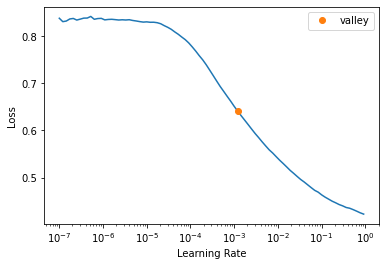

In [41]:
learn.lr_find()

From this curve we can see that the loss hits a minimum around a learning rate of $10^{-1}$, so we should select a learning rate lower than this point. The `lr_find()` method provides a handy heuristic to pick the learning rate 1-2 orders of magnitude less than the minimum, as indicated by the orange dot. 

### Train your model

In the above learning rate plot, it appears a learning rate of around 1e-3 would be good, so let's choose that and train our models for 3 epochs:

In [42]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.233523,0.238331,0.899719,0.963584,00:08
1,0.224499,0.225737,0.904042,0.968218,00:08
2,0.220300,0.223208,0.905206,0.968596,00:08


Once the model is trained, we can view the results in various ways. A simple approach is to use the `show_results()` method to compare the model errors:

In [28]:
learn.show_results()

,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,is_signal_new,is_signal_new_pred
0,-1.947309,0.926203,0.270699,-0.114332,1.249062,0.595708,-0.050255,0.315546,-0.052304,-0.063876,0.097168,-0.048806,1.0,1.0
1,0.879042,-0.368789,-0.231403,-0.139125,0.014944,-0.075256,-0.072862,-0.172220,-0.129792,-0.051958,-0.053092,-0.044962,1.0,1.0
2,0.803042,-1.738004,-0.576891,-0.159969,-1.816268,-0.627292,-0.107585,-1.883698,-0.676825,-0.069955,-0.679554,-0.054457,0.0,0.0
3,0.481037,0.874037,0.245544,-0.118403,0.556596,0.172138,-0.077974,0.027121,-0.105609,-0.062644,-0.474316,-0.053557,1.0,1.0
4,-0.984107,0.303840,0.009448,-0.127366,1.131559,0.434795,-0.068384,0.860640,0.384995,-0.045383,0.651991,-0.029641,1.0,1.0
5,0.106860,-0.679268,-0.375832,-0.154271,-0.522182,-0.244822,-0.094518,-0.375993,-0.198173,-0.062035,-0.180509,-0.048787,0.0,0.0
6,2.403219,-0.958923,-0.472849,-0.159017,-1.599104,-0.598868,-0.107379,-1.673422,-0.652416,-0.069832,-0.679554,-0.054457,0.0,0.0
7,0.136110,0.489993,0.131335,-0.109151,0.511853,0.020762,-0.093840,0.996578,0.314105,-0.054156,0.480184,-0.032850,1.0,0.0
8,1.945964,-1.420909,-0.524806,-0.157572,-1.066425,-0.497073,-0.101179,-0.930981,-0.491751,-0.063756,-0.524255,-0.053857,0.0,0.0


Here we can see that model only made a handful of errors, which is expected since our accuracy is already around 90%. Evaluating our model’s predictions on the same data it was trained on is almost always a recipe for disaster! Why? The problem is that the model may memorise the structure of the data it sees and fail to provide good predictions when shown new data. Let's see how we can evaluate our model on the _test set_.

### Evaluate your model

The learners in fastai are equipped with `predict()` and `get_preds()` methods that allow one to evaluae the model on new data. To use them, we'll need a new `DataLoader` which we can create by simply passing in a `DataFrame` of the test events:

In [18]:
test_df = nsubjet_ds["test"].to_pandas()
test_dl = learn.dls.test_dl(test_items=test_df)

Now that we have a `DataLoader`, it's a simple matter to compute the predictions with the `get_preds()` method:

In [19]:
preds, targs = learn.get_preds(dl=test_dl)
# Check the sizes of the predictions and targets
preds.size(), targs.size()

(torch.Size([404000, 2]), torch.Size([404000, 1]))

Here we can see that the predictions are stored in a 2D tensor, where each dimension corresponds to the _probabilities_ of the model for the two classes (signal vs background). Now, ROC curves effectively plot signal efficiency versus background rejection at various thresholds of some discriminating variable. Here that variable will be the output signal score of our neural network. To visualise the ROC curve we thus first need the scores for the signal and background predictions:

In [20]:
signal_test = preds[:, 1][targs.flatten() == 1].numpy()
background_test = preds[:, 1][targs.flatten() == 0].numpy()

We can then plot a histogram to visualise the distribution of the probabilities:

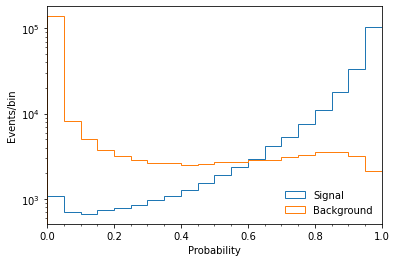

In [21]:
plt.subplots()
plt.hist(signal_test, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.minorticks_on()

plt.legend(loc="lower right", frameon=False)
plt.show()

We see that although the model assigns high (low) probabilities to the signal (background) events, a fair amount of the signal events overlap with background ones.  To handle this, one usually defines a "cut" or threshold that only includes events above that value. For example, if define the cut at 0, then all the events are counted and the signal efficiency $\epsilon_S$ and background efficieny $\epsilon_B$ are both 1. As we increase the cut, we reject more and more background events and the result is a ROC curve with $\epsilon_{B,S}$ ranging from 0 to 1.

To visualise the ROC curve, we can use the handy `roc_curve()` function from scikit-learn:

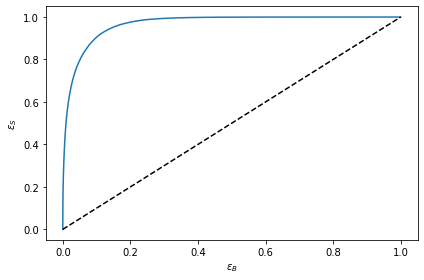

In [22]:
# fpr = epsilon_B, tpr = epsilon_S
fpr, tpr, thresholds = roc_curve(y_true=targs, y_score=preds[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

A perfect classifier would have a ROC curve with all signal and background events correctly identified, i.e. an area of 1. Let's compute this area along with the accuracy on the test set:

In [23]:
acc_test = accuracy_score(targs, preds.argmax(dim=-1))
auc_test = auc(fpr, tpr)
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")

Accuracy: 0.9014
AUC: 0.9671


Since the AUC is dominated by values at large $\epsilon_B$, it is common to also report the background rejection at a fixed signal efficiency (often 30%). We can do that bu defining an interpolating function across the `tpr` and `fpr` values as follows:

In [24]:
background_eff = interp1d(tpr, fpr)
background_eff_at_30 = background_eff(0.3)
print(f"The backround rejection at signal efficiency 0.3 is {1/background_eff_at_30:0.3f}")

The backround rejection at signal efficiency 0.3 is 365.786


Comparing these results again the [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) review, shows that our model hasn't done too poorly - only a few percentage points behind the state-of-the-art from 2019 and it only took around a minute to train our model!

<img src="images/top-tagging-scores.png" alt="fishy" class="bg-primary mb-1" width="800px">

To wrap up, let's visualise the ROC curves in terms of background rejection and signal efficiency:

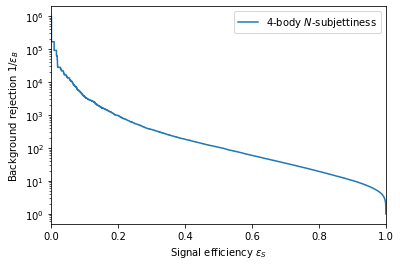

In [25]:
plt.plot(tpr, 1 / (fpr + 1e-6), label="4-body $N$-subjettiness")
plt.xlabel("Signal efficiency $\epsilon_{S}$")
plt.ylabel("Background rejection $1/\epsilon_{B}$")
plt.xlim(0, 1)
plt.yscale("log")
plt.legend()
plt.show()

## Scratch for CNNs

In [1]:
from fastai.vision.all import *

In [20]:
images_ds = load_dataset("dl4phys/top_landscape_images")

Using custom data configuration dl4phys--top_landscape_images-1db221bb78f88b54
Reusing dataset parquet (/home/lewis/.cache/huggingface/datasets/parquet/dl4phys--top_landscape_images-1db221bb78f88b54/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
def transforms(examples):
    examples["image"] = [np.array(image) for image in examples["image"]]
    return examples

transformed_dataset = images_ds.with_transform(transforms)

In [22]:
from torch.utils.data import DataLoader

In [45]:
train_dataloader = DataLoader(
     transformed_dataset["train"], batch_size=32, shuffle=True, num_workers=1
)
test_dataloader = DataLoader(
     transformed_dataset["test"], batch_size=32, shuffle=True, num_workers=1
)

In [46]:
next(iter(train_dataloader))

{'image': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
   

In [47]:
train_dataloader.dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1211000
})

In [48]:
dls = DataLoaders(train_dataloader, test_dataloader)

In [101]:
dls.after_batch.fs

AttributeError: 'function' object has no attribute 'fs'

In [95]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

AttributeError: 'function' object has no attribute 'fs'

In [103]:
path = untar_data(URLs.PETS)


In [104]:
files = get_image_files(path/"images")


In [105]:
def label_func(f): return f[0].isupper()


In [106]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))


In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

AttributeError: 'function' object has no attribute 'fs'

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms


In [5]:
tfms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081))
])

In [53]:
train_dset = datasets.MNIST('./data', train=True, download=True, transform=tfms)


In [54]:
train_dset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=0.3081)
           )

In [55]:
train_loader = DataLoader(train_dset, batch_size=256, 
                          shuffle=True, num_workers=1, pin_memory=True)

In [57]:
next(iter(train_loader))

2

In [34]:
dls = DataLoaders(train_loader)


In [35]:
from torch import nn

In [36]:
class Flatten(nn.Module):
    "Flattens an input"
    def forward(self, x): return x.view(x.size(0), -1)

In [41]:
class Net(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1), 
            # A head to the model
            nn.MaxPool2d(2), nn.Dropout2d(0.25),
            Flatten(), nn.Linear(9216, 128), nn.ReLU(),
            nn.Dropout2d(0.5), nn.Linear(128, 10), nn.LogSoftmax(dim=1)
        )

In [42]:
import torch.nn.functional as F


In [49]:
learn = Learner(dls, Net(), loss_func=F.nll_loss)

In [50]:
learn.lr_find()

TypeError: unhashable type: 'slice'